# NSSP - Miniproject1

In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
sys.path.append('../Labs')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

In [2]:
################
# Start FSLeyes within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

09:29:27: Debug: Adding duplicate image handler for 'Windows bitmap file'
09:29:27: Debug: Adding duplicate animation handler for '1' type
09:29:27: Debug: Adding duplicate animation handler for '2' type
09:29:28: Debug: Adding duplicate image handler for 'Windows bitmap file'
09:29:28: Debug: Adding duplicate animation handler for '1' type
09:29:28: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:710): Gtk-CRITICAL **: 09:29:28.667: gtk_window_resize: assertion 'height > 0' failed


In [3]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')
        
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data

## 0. Download Datasets

In [6]:
dataset_id = 'ds000171'
subject = 'control01' 

sample_path = "/home/jovyan/Data/dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

subject_dir = 'sub-{}'.format(subject)

###################
# Openneuro download.
###################
subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, # Openneuro has for each dataset a unique identifier
                "--target-dir", bids_root,  # The path where we want to save our data. You should save your data under /home/jovyan/Data/[your dataset ID] to be 100% fool-proof
                "--include", op.join(subject_dir, '*'),# We are asking to get all files within the subject_dir/anat folder by using the wildcard *
               ], check=True)

###################
# Create folders relevant for preprocessing.
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, subject_dir))
mkdir_no_exist(op.join(preproc_root, subject_dir, 'anat'))
mkdir_no_exist(op.join(preproc_root, subject_dir, 'func'))
mkdir_no_exist(op.join(preproc_root, subject_dir, 'fmap'))


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds000171 …


📁 Traversing directories for ds000171 : 436 entities [00:30, 14.24 entities/s]


📥 Retrieving up to 15 files (5 concurrent downloads). 


sub-control01_T1w.nii.gz:   1%|          | 83.6k/8.77M [00:00<00:19, 465kB/s]
sub-control01_task-music_run-2_events.tsv:   0%|          | 0.00/339 [00:00<?, ?B/s]
                                                                                    
sub-control01_T1w.nii.gz:   3%|▎         | 271k/8.77M [00:00<00:08, 1.10MB/s]0<?, ?B/s]

sub-control01_task-music_run-3_bold.nii.gz:   0%|          | 0.00/33.9M [00:00<?, ?B/s]


sub-control01_task-music_run-2_bold.nii.gz:   0%|          | 0.00/33.9M [00:00<?, ?B/s]
sub-control01_T1w.nii.gz:   7%|▋         | 611k/8.77M [00:00<00:05, 1.57MB/s]00<01:14, 473kB/s]



sub-control01_task-music_run-3_events.tsv:   0%|          | 0.00/339 [00:00<?, ?B/s]



                                                                                    

sub-control01_T1w.nii.gz:  18%|█▊        | 1.58M/8.77M [00:00<00:01, 4.17MB/s]0<02:06, 280kB/s]


sub-control01_task-music_run-2_bold.nii.gz:   0%|          | 83.6k/33.9M [00:00<01:15, 469kB/s]
sub-control01_T1w.

✅ Finished downloading ds000171.
 
🧠 Please enjoy your brains.
 


In [8]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|------------ fmap/
|------------ func/
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv
|--------- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-4_events.tsv
|--------- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-5_events.tsv


## 1. Anatomical preprocessing

In [9]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root,subject_dir,'anat', 'sub-control01_T1w.nii.gz'))


(ipykernel_launcher.py:710): Gdk-WARNING **: 09:31:30.762: gdkdrawable-x11.c:952 drawable is not a pixmap or window


### 1.1 Remove the skull

In [10]:
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    subject = 'sub-{}'.format(subject_id)
    anatomical_path = op.join(bids_root, subject, 'anat', 'sub-{}_T1w.nii.gz'.format(subject_id))
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask')

In [11]:
# improve the fit
get_skull_stripped_anatomical(bids_root, preproc_root, "control01", robust=True)

fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, subject_dir, 'anat', 'sub-control01_T1w.nii.gz'))
fsleyesDisplay.load(resulting_mask_path)

Done with BET.


#### * After improving the fit, do mannual corrections if needed. Then apply the mask to T1 through fslmaths.

In [12]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    """Apply resulted mask to T1"""
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    

anatomical_path = op.join(bids_root, subject_dir, 'anat', 'sub-control01_T1w.nii.gz') # The original brain
betted_brain_path = op.join(preproc_root, subject_dir, 'anat', 'sub-control01_T1w.nii.gz') # The brain without skull is in the derivatives folder
resulting_mask_path = op.join(preproc_root, subject_dir, 'anat', 'sub-control01_T1w_mask.nii.gz') # The mask to use

apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [13]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

### 1.2 Tissue segmentation

In [14]:
bet_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w')

fast_target = bet_path 
[os.remove(f) for f in glob.glob(op.join(preproc_root, 'sub-control01', 'anat', '*fast*'))] # Just to clean the directory in between runs of the cell
segmentation_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

{}

In [15]:
#check the segmentation result with RGB
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(bet_path)
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-control01', 'anat','*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-control01', 'anat','*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-control01', 'anat','*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

### 1.3 Coregistration
Aim: to make participant's brain match with a reference brain so that comparison across participants become feasible.

Here we use linear normalization by flirt().

In [16]:
from fsl.wrappers import flirt

subject_id = 'control01'
subject_anatomical = op.join(preproc_root, subject_dir, 'anat', 'sub-control01_T1w')
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))

target = subject_anatomical 
reference = mni_template 
result = op.join(preproc_root, subject_dir, 'anat', 'sub-{}_T1w_mni'.format(subject_id))
flirt(target, reference, out=result)


Final result: 
0.003348 0.005721 -1.116064 204.794610 
-0.933350 0.500887 0.005750 178.784833 
0.501418 1.048657 -0.003251 -149.700516 
0.000000 0.000000 0.000000 1.000000 



{}

In [17]:
#Visualize the result
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(reference) 
fsleyesDisplay.load(result)

## 2. Standardize T2 files

#### Before standardization, extract brain tissue.

In [18]:
def get_skull_stripped_func(bids_root, preproc_root, subject_id, run = 1, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T2w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    subject = 'sub-{}'.format(subject_id)
    func_path = op.join(bids_root, subject, 'func', f'sub-{subject_id}_task-music_run-{run}_bold.nii.gz')
    betted_brain_path = op.join(preproc_root, subject, 'func', f'sub-{subject_id}_task-music_run-{run}_bold.nii.gz')
    os.system('bet {} {} -m {}'.format(func_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")


In [19]:
for i in range(3):
    run = i+1
    get_skull_stripped_func(bids_root, preproc_root,"control01", run=run, robust=True)

    func_path = op.join(bids_root, subject_dir, 'func', f'sub-control01_task-music_run-{run}_bold.nii.gz') # The original brain
    betted_brain_path = op.join(preproc_root, subject_dir, 'func', f'sub-control01_task-music_run-{run}_bold.nii.gz') # The brain without skull is in the derivatives folder
    resulting_mask_path = op.join(preproc_root, 'sub-control01', 'func', f'sub-control01_task-music_run-{run}_bold_mask.nii.gz')
    
    apply_fsl_math_approach(func_path, resulting_mask_path, betted_brain_path)

Done with BET.


Done with BET.


Done with BET.


#### Verify possible problematic volumes

In [21]:
subject

'control01'

In [25]:
file

'sub-control01_task-music_run-1_bold.nii.gz'

Text(0.5, 1.0, 'Mean BOLD Signal After Brain Extraction')

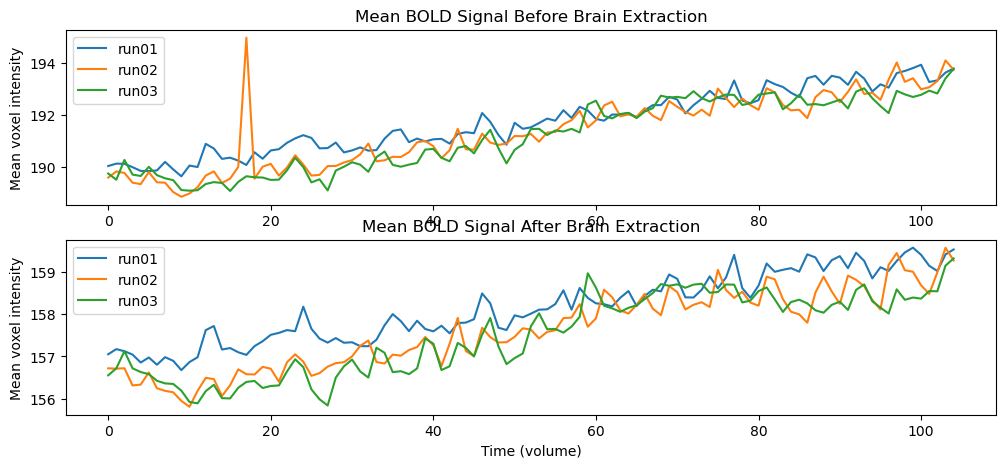

In [26]:
# Visualize mean voxel intensity of bold files
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
for run_idx in range(1, 3+1):
    plt.plot(nib.load(op.join(bids_root, f'sub-{subject}','func', f'sub-control01_task-music_run-{run_idx}_bold.nii.gz')).get_fdata().mean(axis=(0,1,2)), label=f'run0{run_idx}')
plt.legend()
plt.ylabel('Mean voxel intensity')
plt.title('Mean BOLD Signal Before Brain Extraction')

plt.subplot(2, 1, 2)
for run_idx in range(1, 3+1):
    plt.plot(nib.load(op.join(preproc_root, f'sub-{subject}','func', f'sub-control01_task-music_run-{run_idx}_bold.nii.gz')).get_fdata().mean(axis=(0,1,2)), label=f'run0{run_idx}')
plt.legend()
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')
plt.title('Mean BOLD Signal After Brain Extraction')

Since we did not find any obvious problematic volumes according to the above figure, we skipped removing the problematic volumes.

#### Standardize and concact all runs of interest.

In [34]:
import nibabel as nib
import numpy as np

def standardize_session(file_path):
    # Load MRI data using nibabel
    img = nib.load(file_path)
    data = img.get_fdata()

    # Compute mean and standard deviation of the session
    mean = np.mean(data)
    std = np.std(data)

    # Standardize (z-score)
    standardized_data = (data - mean) / std

    # Save the standardized data
    standardized_img = nib.Nifti1Image(standardized_data, img.affine, img.header)
    output_path = file_path.replace('.nii.gz', '_standardized.nii.gz')
    nib.save(standardized_img, output_path)

    print(f'Saved standardized image to {output_path}')
    return output_path

In [35]:
original_file_dir = op.join(preproc_root,subject_dir,'func')

standardized_files = []

for file in os.listdir(original_file_dir):
    if '_task-music_run' in file and file.endswith('_bold.nii.gz'):
        file_path = op.join(original_file_dir,file)
        standardized_file = standardize_session(file_path)
        img = nib.load(standardized_file)
        data = img.get_fdata()
        standardized_files.append(data)

concatenated_data = np.concatenate(standardized_files, axis=3)

# Save the concatenated data
mkdir_no_exist(op.join(preproc_root, subject_dir, 'func'))
mkdir_no_exist(op.join(preproc_root, subject_dir, 'fmap'))
concatenated_img = nib.Nifti1Image(concatenated_data, img.affine, img.header)
concatenated_fil_out_path = op.join(preproc_root, subject_dir, 'func','sub-control01_task-music_run_concatenated.nii.gz')
nib.save(concatenated_img, concatenated_fil_out_path)

print(f'Concatenated all sessions and saved to {concatenated_fil_out_path}')

Saved standardized image to /home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-2_bold_standardized.nii.gz
Saved standardized image to /home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_standardized.nii.gz
Saved standardized image to /home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-3_bold_standardized.nii.gz
Concatenated all sessions and saved to /home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run_concatenated.nii.gz


In [36]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_fast_mixeltype.nii.gz
|--------------- sub-control01_T1w_fast_pve_0.nii.gz
|--------------- sub-control01_T1w_fast_pve_1.nii.gz
|--------------- sub-control01_T1w_fast_pve_2.nii.gz
|--------------- sub-control01_T1w_fast_pveseg.nii.gz
|--------------- sub-control01_T1w_fast_seg.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|--------------- sub-control01_T1w_mni.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-control01_task-music_run-1_bold.nii.gz
|--------------- sub-control01_task-music_run-1_bold_mask.nii.gz
|--------------- sub-control01_task-music_run-1_bold_standardized.nii.gz
|--------------- sub-control01_task-music_run-2_bold.nii.gz
|--------------- sub-control01_task-music_run-2_bold_mask.nii.gz
|-

Text(0, 0.5, 'Mean voxel intensity after standardization')

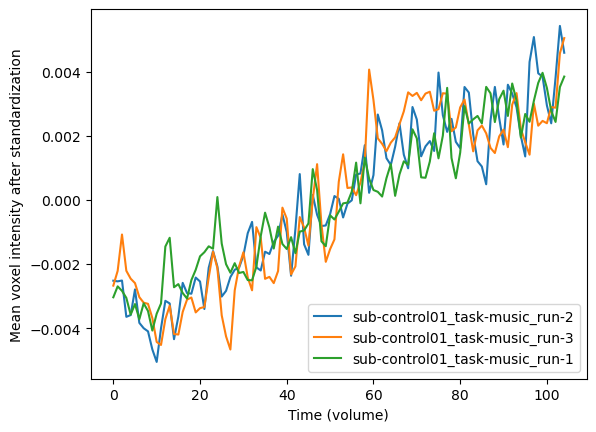

In [37]:
# Visualize mean voxel intensity after standardization
import matplotlib.pyplot as plt

for file in os.listdir(op.join(preproc_root, 'sub-control01','func')):
    if '_task-music_run' in file and file.endswith('_bold_standardized.nii.gz'):
        filename = op.join(preproc_root, 'sub-control01','func',file)

        mean_intensity = nib.load(filename).get_fdata().mean(axis=(0,1,2))
        
        plt.plot(mean_intensity,label = file.replace('_bold_standardized.nii.gz',''))

plt.legend()
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity after standardization')

## 3. Motion correction

In [38]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(preproc_root, 'sub-control01','func', 'sub-control01_task-music_run_concatenated.nii.gz'))

In [39]:
from fsl.wrappers import mcflirt

path_original_data = op.join(preproc_root, subject_dir,'func', 'sub-control01_task-music_run_concatenated.nii.gz')
path_moco_data = os.path.join(preproc_root, subject_dir, 'func', 'sub-control01_task-music_run_concatenated_moco')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run_concatenated_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288]

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][

{}

In [40]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(path_moco_data)

In [41]:
# check the the resulting correction parameters

def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, subject_dir, 'func', 'sub-control01_task-music_run_concatenated_moco.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,0.003579,-0.001914,-0.000897,-0.056796,0.120750,-0.014509
1,0.003245,-0.001664,-0.000970,-0.064549,0.152622,0.008203
2,0.003687,-0.001931,-0.000795,-0.053205,0.143015,0.025516
3,0.003245,-0.002375,-0.000703,-0.038205,0.175101,0.044440
4,0.003245,-0.002068,-0.000572,-0.040074,0.196084,0.091582
...,...,...,...,...,...,...
310,0.018324,-0.002975,-0.002443,-0.031626,0.960422,0.784622
311,0.018513,-0.002954,-0.002513,-0.029655,0.926141,0.784486
312,0.018302,-0.003234,-0.002513,-0.030656,0.949883,0.781924
313,0.018005,-0.003269,-0.002513,-0.047232,0.932789,0.754728


In [44]:
# Check the displacement on a 50mm radius sphere

def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

In [45]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

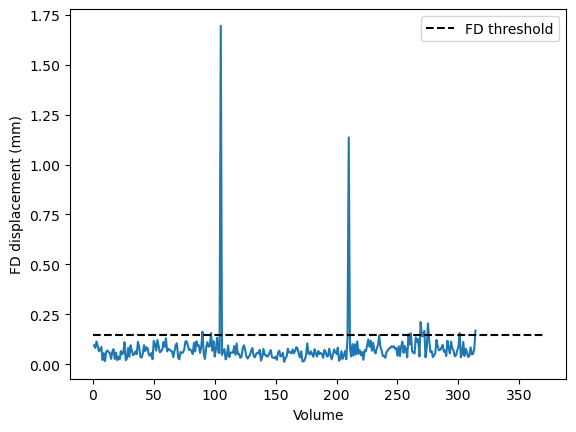

In [46]:
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [47]:
np.where(fd > threshold)[0] + 1

array([ 90,  97, 105, 210, 259, 261, 269, 272, 275, 301, 314])

## 4.Coregistration of functional to anatomical

In [ ]:
from fsl.wrappers import epi_reg

epi_target = op.join(preproc_root, subject_dir, 'func', 'sub-control01_task-music_run_concatenated_moco')
whole_t1 = op.join(bids_root, subject_dir, 'anat', 'sub-control01_T1w')
skull_stripped_t1 = op.join(preproc_root, subject_dir, 'anat', 'sub-control01_T1w')
white_matter_segmentation = op.join(preproc_root, subject_dir, 'anat', 'sub-control01_T1w_fast_pve_2.nii.gz') # Use the white matter segmentation

output_path = op.join(preproc_root, subject_dir, 'func', 'sub-control01_task-music_run_concatenated_bbr')
ref_vol_name =  op.join(preproc_root, subject_dir, 'func', 'sub-control01_task-music_run_concatenated_moco_vol_middle')

use_single_vol = True

"""
if use_single_vol:
    # Extract the middle volume with fslroi as we've seen before :)
    middle_index= nib.load(op.join(preproc_root, subject_dir, 'func', 'sub-control01_task-music_run_concatenated.nii.gz')).shape[3]//2
    fslroi(epi_target, ref_vol_name, str(middle_index), str(1))
    # Call epi_reg
    subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), 
                '--out={}'.format(output_path),
               '--wmseg={}'.format(white_matter_segmentation)])
else:
    subprocess.run(['epi_reg','--epi={}'.format(epi_target), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), 
                '--out={}'.format(output_path),
               '--wmseg={}'.format(white_matter_segmentation)])
"""
if use_single_vol:
    # Extract the middle volume with fslroi as we've seen before :)
    middle_index= nib.load(op.join(preproc_root, subject_dir, 'func', 'sub-control01_task-music_run_concatenated.nii.gz')).shape[3]//2
    fslroi(epi_target, ref_vol_name, str(middle_index), str(1))
    # Call epi_reg
    subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), '--out={}'.format(output_path)])
else:
    subprocess.run(['epi_reg','--epi={}'.format(epi_target), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), '--out={}'.format(output_path)])



In [58]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(skull_stripped_t1)
fsleyesDisplay.load(output_path)

## Smoothing

In [59]:
# Load the image & get the voxel size
img = nib.load(op.join(preproc_root, 'sub-control01','func', 'sub-control01_task-music_run-1_bold.nii.gz'))
voxel_size = img.header.get_zooms()[:3] 
voxel_size

(2.9, 2.9, 3.0)

In [60]:
# Choose 6mm as FWHM
cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])

CompletedProcess(args=['fslmaths', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run_concatenated_bbr', '-s', '2.547987090198743', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run_concatenated_bbr_smoothed-6mm'], returncode=0)

In [61]:
fsleyesDisplay.load(output_path + '_smoothed-6mm')